In [805]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import wiener
from skimage.exposure import equalize_adapthist, equalize_hist
from skimage.filters import unsharp_mask
from skimage.morphology import binary_opening, remove_small_objects, disk, remove_small_holes, binary_dilation

from src.filters import normalize_0_255, sobel, yen_th
from src.fish.well_meniscus import get_menisc
from src.models import InputImage
from src.utils import keep_largest_object, keep_second_largest_object
from src.well.find_well_props import find_well_props

# Searching for well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for well
_____________________________________________________________
# Circle mask for well created
_____________________________________________________________
# Creating remaining masks:
_____________________________________________________________
# Creating cropped mask
_____________________________________________________________
# Creating masked image (original)
_____________________________________________________________
# Creating masked image (cropped)
_____________________________________________________________
# Created remaining masks
_____________________________________________________________
# Finished searching for well properties
_____________________________

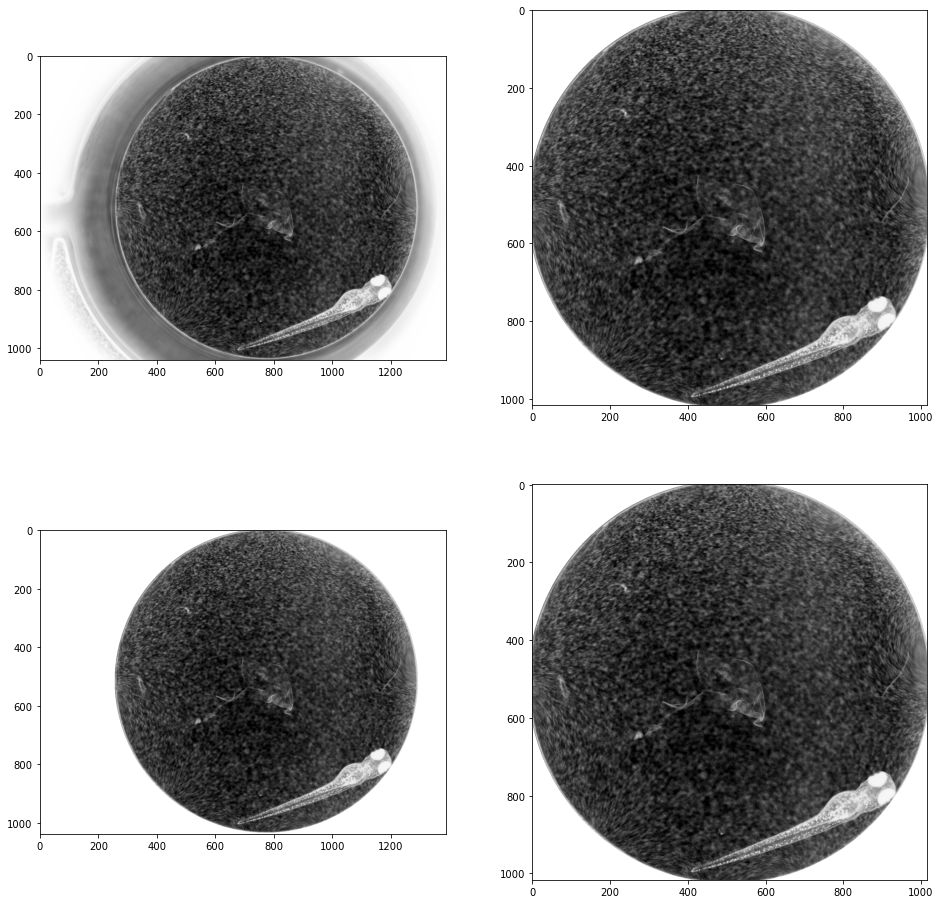

In [806]:
input_img = InputImage("zf3.czi")

input_img.processed = normalize_0_255(input_img.processed)
input_img.processed = np.uint8(input_img.processed)
input_img = find_well_props(input_img)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(input_img.og, 'binary')
ax[1].imshow(input_img.processed, 'binary')
ax[2].imshow(input_img.well_props.mask.masked, 'binary')
ax[3].imshow(input_img.well_props.mask.cropped_masked, 'binary')

C:\Users\gimesia\.anaconda3\envs\ZF\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
C:\Users\gimesia\.anaconda3\envs\ZF\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


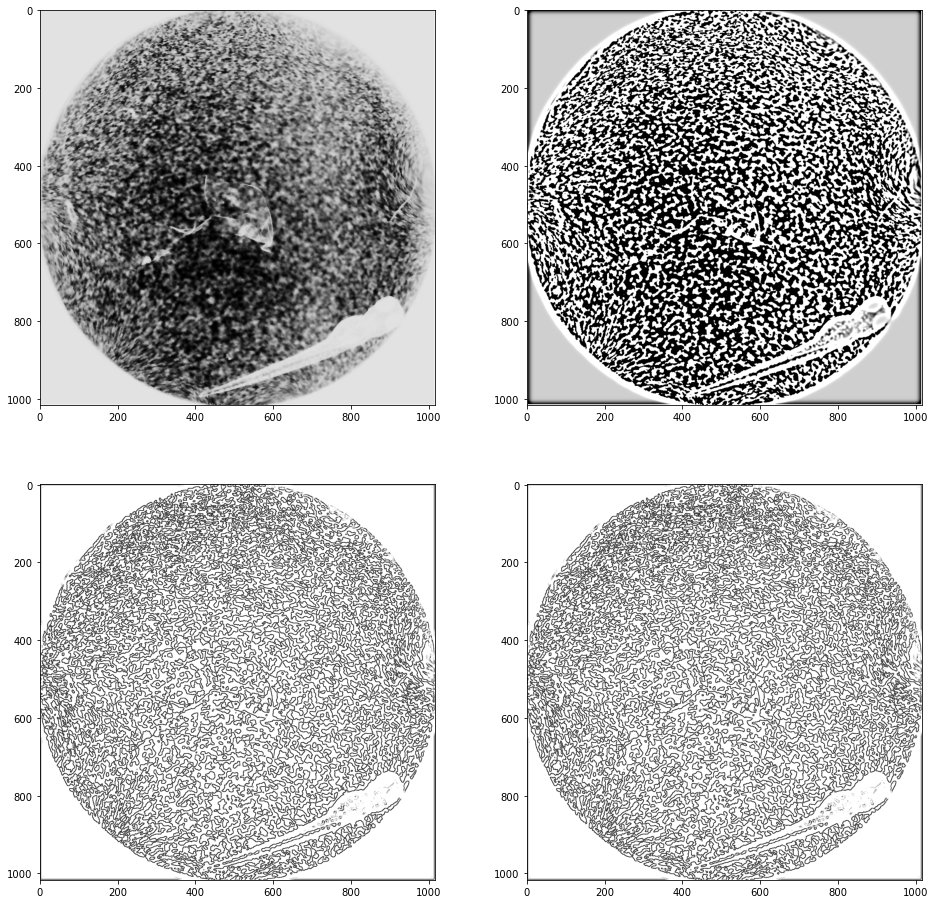

In [807]:
from skimage.restoration import denoise_wavelet
from skimage.filters.ridges import frangi, meijering

masked = input_img.well_props.mask.cropped_masked

a = equalize_hist(masked)
b = wiener(a, (5, 5))
c = unsharp_mask(b, amount=60, radius=6)
d = sobel(c)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(b, 'binary')
ax[1].imshow(c, 'binary')
ax[2].imshow(d, 'binary')
ax[3].imshow(d, 'binary')

In [808]:
from skimage.filters.thresholding import threshold_triangle

um_a = 40
um_r = 2
wiener_size = (5, 5)


def way_1(img):
    a_ = equalize_hist(img)
    b_ = unsharp_mask(a_, amount=um_a, radius=um_r)
    c_ = wiener(b_, wiener_size)
    d_ = sobel(c_)
    return yen_th(d_)


def way_2(img):
    a_ = equalize_hist(img)
    b_ = unsharp_mask(a_, amount=um_a, radius=um_r)
    c_ = wiener(b_, wiener_size)
    d_ = threshold_triangle(c_) > c_
    return d_


In [809]:
w1 = way_1(input_img.well_props.mask.cropped_masked)
w2 = way_2(input_img.well_props.mask.cropped_masked) * input_img.well_props.mask.cropped

w1_menisc = get_menisc(w1, input_img.well_props.mask.cropped)
w2_menisc = get_menisc(w2, input_img.well_props.mask.cropped)

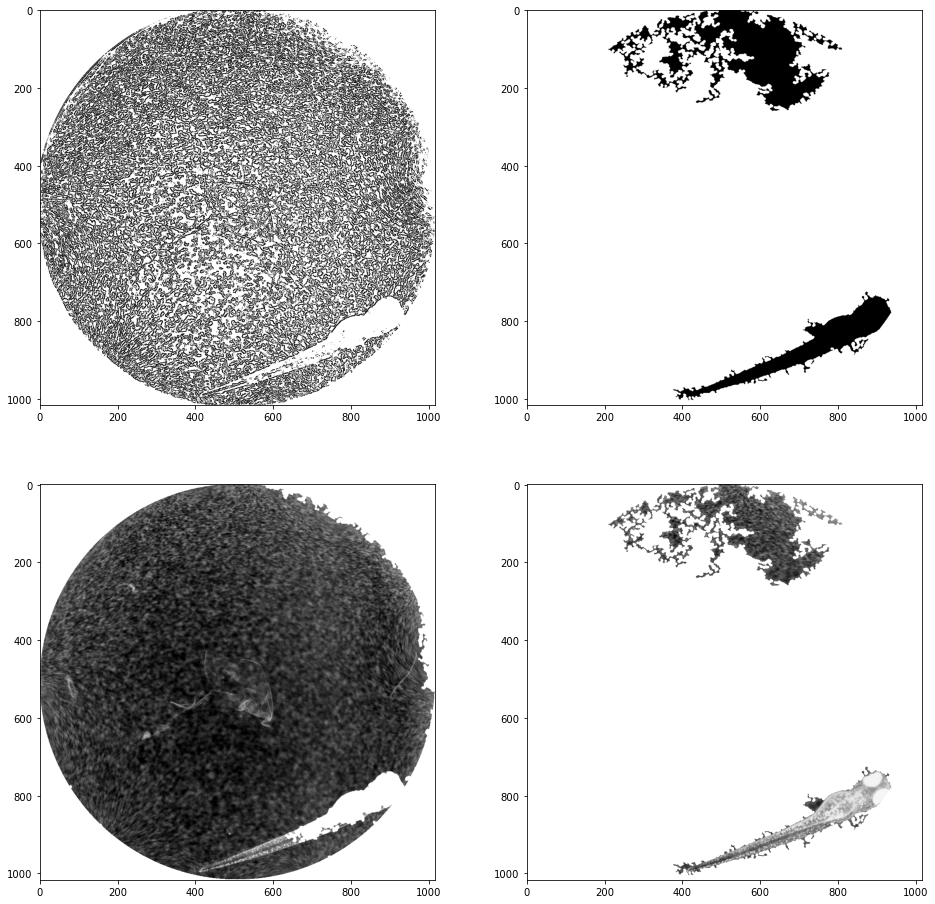

In [810]:
from skimage.morphology import binary_closing
from scipy.ndimage import binary_fill_holes


se = disk(3)

w1_klo = remove_small_objects(remove_small_holes(binary_closing(w1, se), area_threshold=w1.size * 0.05),
                              min_size=w1.size * 0.01) * input_img.well_props.mask.cropped
w2_klo = remove_small_objects(remove_small_holes(binary_closing(w2, se), area_threshold=w2.size * 0.05),
                              min_size=w1.size * 0.01) * input_img.well_props.mask.cropped

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(w1, 'binary')
ax[1].imshow(w2_klo, 'binary')
ax[2].imshow(w1_klo * input_img.well_props.mask.cropped_masked, 'binary')
ax[3].imshow(w2_klo * input_img.well_props.mask.cropped_masked, 'binary')

In [811]:
def _2x2(binary_img: np.ndarray):
    remaining_binary_img = binary_img.copy()

    mh, mw = binary_img.shape
    h_center, w_center = int(mh / 2), int(mw / 2)

    lt = remaining_binary_img[0:h_center, 0:w_center]
    lb = remaining_binary_img[h_center:mh, 0:w_center]
    rt = remaining_binary_img[0:h_center, w_center:mw]
    rb = remaining_binary_img[h_center:mh, w_center:mw]

    left_side = np.concatenate((lt, lb), axis=0)
    right_side = np.concatenate((rt, rb), axis=0)

    return lt, lb, rt, rb

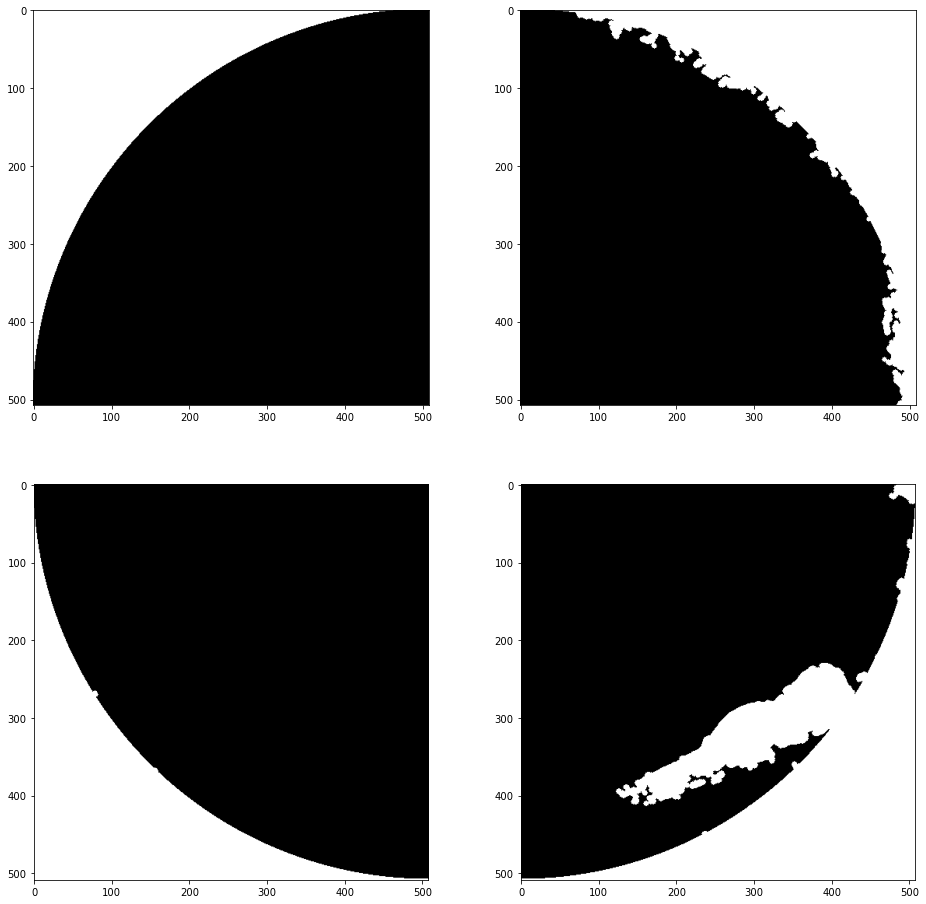

In [812]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

lt, lb, rt, rb = _2x2(w1_klo)
ax[0].imshow(lt, 'binary')
ax[1].imshow(rt, 'binary')
ax[2].imshow(lb, 'binary')
ax[3].imshow(rb, 'binary')

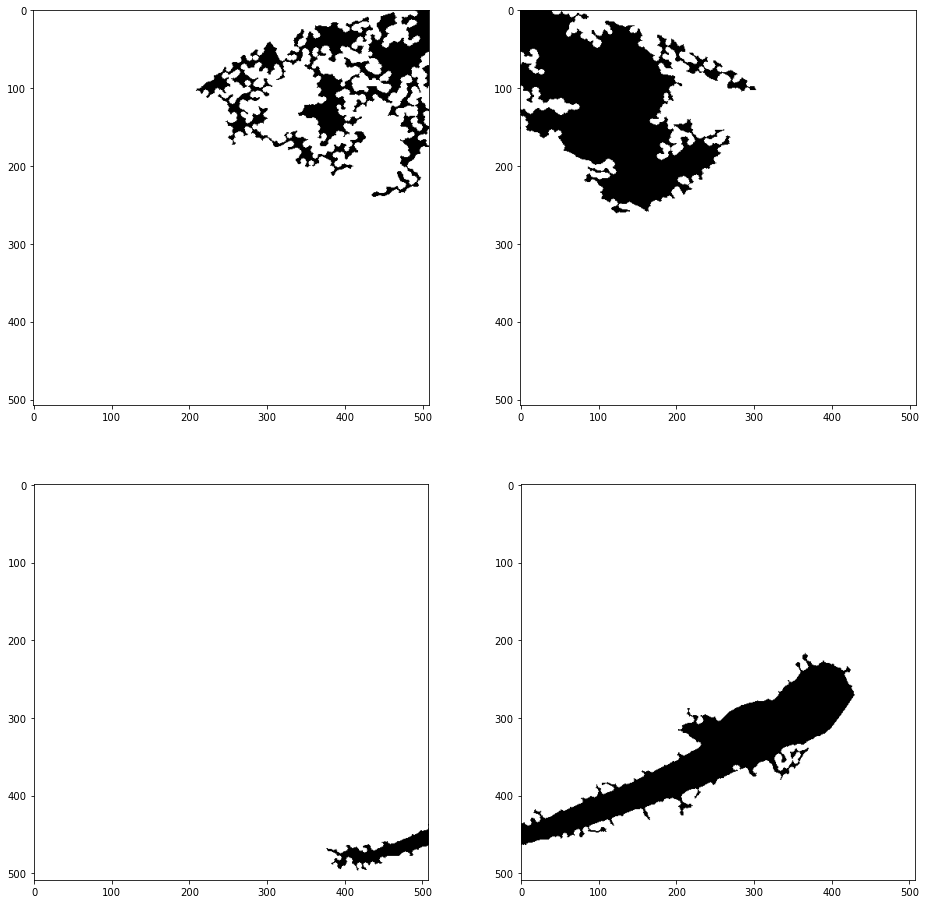

In [813]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

lt, lb, rt, rb = _2x2(w2_klo)
ax[0].imshow(lt, 'binary')
ax[1].imshow(rt, 'binary')
ax[2].imshow(lb, 'binary')
ax[3].imshow(rb, 'binary')

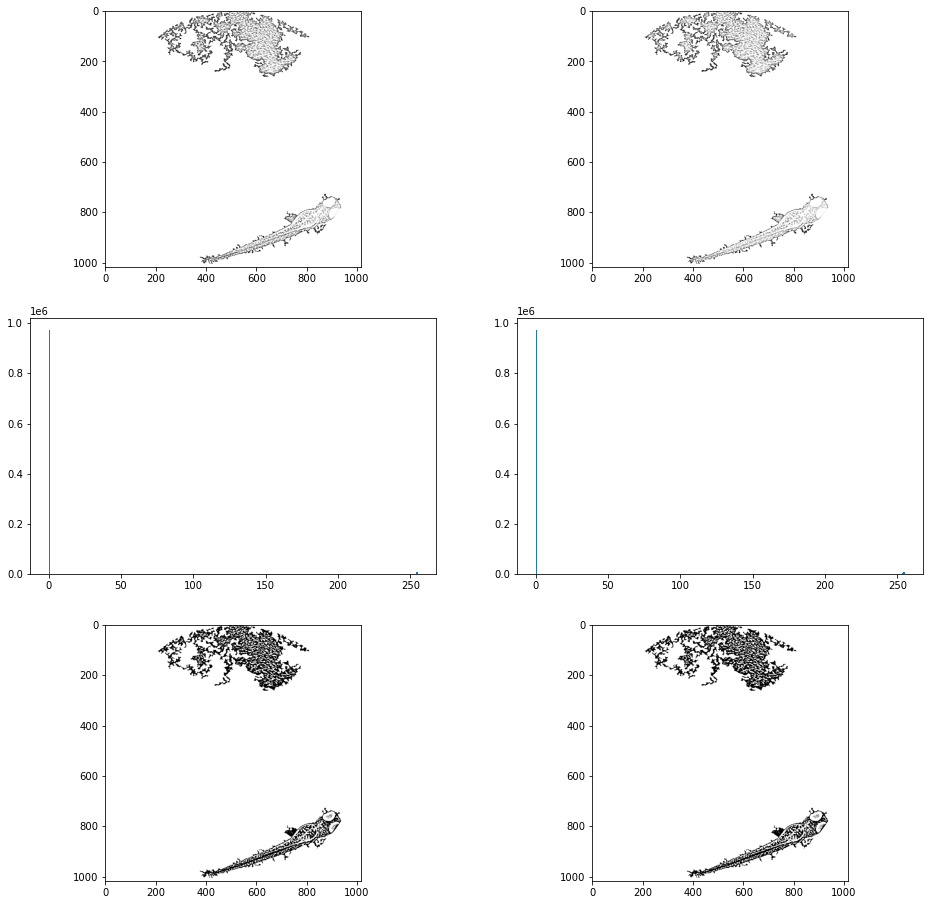

In [814]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
ax = ax.ravel()

masked = w2_klo * input_img.well_props.mask.cropped_masked
masked = unsharp_mask(masked, amount=50, radius=3)

eq_h = normalize_0_255(equalize_hist(masked))
eq_ah =  normalize_0_255(equalize_adapthist(masked))

ax[0].imshow(eq_h, 'binary')
ax[1].imshow(eq_ah, 'binary')
ax[2].hist(eq_h.ravel(), bins=256)
ax[3].hist(eq_ah.ravel(), bins=256)
ax[4].imshow(eq_h > 0.96, 'binary')
ax[5].imshow(eq_ah > 0.2, 'binary')